This tutorial will illustrate how to use Landlab modules to simuate the evolution of channels in an actively uplifting landscape sujected to river incision and diffusion, conditionally affected by a stochastic sequence of storms. 

The landscape evolves according to the equation:
\begin{equation}
 \frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + K_\text{hs} \frac{\partial^2 z}{\partial x^2} + U
\end{equation}
where $K_{sp}$ is the erodibility coefficient on fluvial incision, which is thought to be positively correlated with climate wetness, or storminess (this is hard to quantify) and to be negatively correlated with rock strength (again, rock strength is hard to quantify). $K_{hs}$ is the hillslop diffusivity. $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied rock uplift field.

The fluvial erosion term is also known as the stream power equation. Before using this notebook you should be familiar with this equation from class lectures and reading. 

For a great overview of the stream power equation, see: 

- Whipple and Tucker, 1999, Dynamics of the stream-power river incision model: Implications for height limits of mountain ranges, landscape response timescales, and research needs, Journal of Geophysical Research.

For some great illustrations of modeling with the sream power equation, see:

- Tucker and Whipple, 2002, Topographic outcomes predicted by stream erosion models: Sensitivity analysis and intermodel comparison, Journal of Geophysical Research.

Helpful background on landscape sensitivity to rock uplift rates and patterns can be found here:

- Kirby and Whipple, 2012, Expression of active tectonics in erosional landscapes, Journal of Structural Geology.

This tutorial is modified from Channels_streampower_tutorial and Landlab Component Tutorial, whose Binder link is [this one]( https://mybinder.org/v2/gh/landlab/landlab/master?filepath=notebooks/teaching/welcome_teaching.ipynb).

We are going to use three components from Landlab. First, LinearDiffuser, which we have used in the fault scape evolution tutorial, and two new ones - FastscapeEroder, and FlowAccumulator.

[FastscapeEroder](https://landlab.readthedocs.io/en/latest/reference/components/stream_power.html) uses Braun-Willett Fastscape approach to calculate the amount of erosion at each node in a grid, following a stream power framework. Note that the scheme is nominally implicit and will reach a numerically-correct solution under topographic steady state regardless of timestep length. The accuracy of transitent solutions is not timestep independent (see Braun & Willett 2013, Appendix B for more details).  

[FlowAccumulator](https://landlab.readthedocs.io/en/latest/reference/components/flow_accum.html) accumulates flow and calculate drainage area according to a variety of methods that can be specified by users.

For more details, please refer to the links to their documentation.

## Landscape evolution by river incision with and without diffusion

In [2]:
#!pip install landlab numpy matplotlib 
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.pyplot import figure, plot, title, xlabel, ylabel

from landlab import load_params, RasterModelGrid
from landlab.components import LinearDiffuser, FastscapeEroder, FlowAccumulator
from landlab.plot import imshow_grid

In [3]:
inputs = {"nrows":100, "ncols":100, "dx":0.02, 
         "dt":0.5, "total_time": 100.0, "uplift_rate":0.001,
         "stream_power":{"K_sp":0.3, "m_sp":0.5}, 
          "linear_diffuser":{"linear_diffusivity":0.0001}}
nrows = inputs["nrows"]
ncols = inputs["ncols"]
dx = inputs["dx"]
total_t = inputs["total_time"]
dt = inputs["dt"]
uplift_rate = inputs["uplift_rate"]
totalNumOfTimeSteps = int(total_t // dt)
uplift_per_step = uplift_rate * dt

print('Showing input parameters ', inputs)

Showing input parameters  {'nrows': 100, 'ncols': 100, 'dx': 0.02, 'dt': 0.5, 'total_time': 100.0, 'uplift_rate': 0.001, 'stream_power': {'K_sp': 0.3, 'm_sp': 0.5}, 'linear_diffuser': {'linear_diffusivity': 0.0001}}


In [4]:
mesh = RasterModelGrid((nrows, ncols), dx)
elev = mesh.add_zeros("topographic__elevation", at="node")
initial_roughness = np.random.rand(elev.size) / 100000.0
elev += initial_roughness
# setting up boundary conditions
for edge in (mesh.nodes_at_left_edge, mesh.nodes_at_right_edge):
    mesh.status_at_node[edge] = mesh.BC_NODE_IS_CLOSED
for edge in (mesh.nodes_at_top_edge, mesh.nodes_at_bottom_edge):
    mesh.status_at_node[edge] = mesh.BC_NODE_IS_FIXED_VALUE

/home/users3/tb22357/.local/lib/python3.10/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/home/users3/tb22357/.local/lib/python3.10/site-packages/landlab/graph/graph.py:535: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
/home/users3/tb22357/.local/lib/python3.10/site-packages/landlab/graph/graph.py:984: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dim

In [5]:
# instantiate components
fr = FlowAccumulator(mesh)
sp = FastscapeEroder(mesh, **inputs["stream_power"]) # ** in front of 'inputs' dictionary will let the componet to find necessary keywords and their values. 
lin_diffuse = LinearDiffuser(mesh, **inputs["linear_diffuser"])

In [6]:
def timeLoopDriver(lin_diffuse, fr, sp, mesh, elev, dt, 
                   uplift_per_step, totalNumOfTimeSteps, 
                    diffusionOrNot=False):
    for i in range(totalNumOfTimeSteps):
        if diffusionOrNot==True:
            lin_diffuse.run_one_step(dt)
        else:
            if i==0:
                print('Diffusion is not activated.')

        fr.run_one_step()
        sp.run_one_step(dt)
        mesh.at_node["topographic__elevation"][
            mesh.core_nodes
        ] += uplift_per_step
        if i% 20 == 0:
            print("Completed loop %d" % i)
    return mesh

Diffusion is not activated.
Completed loop 0
Completed loop 20
Completed loop 40
Completed loop 60
Completed loop 80
Completed loop 100
Completed loop 120
Completed loop 140
Completed loop 160
Completed loop 180


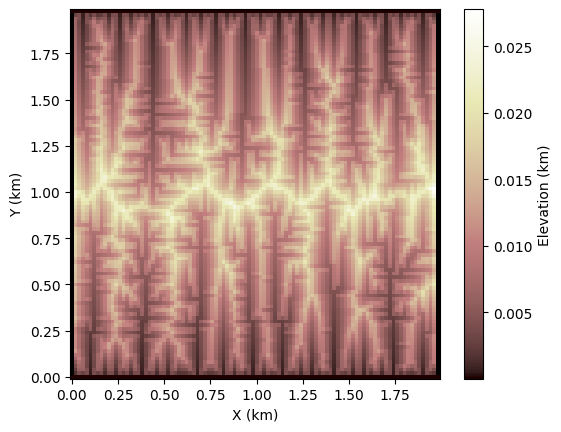

In [7]:
meshNoDiffusion = timeLoopDriver(lin_diffuse, fr, sp, mesh, 
                                 elev, dt, uplift_per_step, totalNumOfTimeSteps,
                                diffusionOrNot=False)
figure("topo with out diffusion")
imshow_grid(
    meshNoDiffusion, "topographic__elevation", grid_units=["km","km"], var_name="Elevation (km)")

Completed loop 0
Completed loop 20
Completed loop 40
Completed loop 60
Completed loop 80
Completed loop 100
Completed loop 120
Completed loop 140
Completed loop 160
Completed loop 180


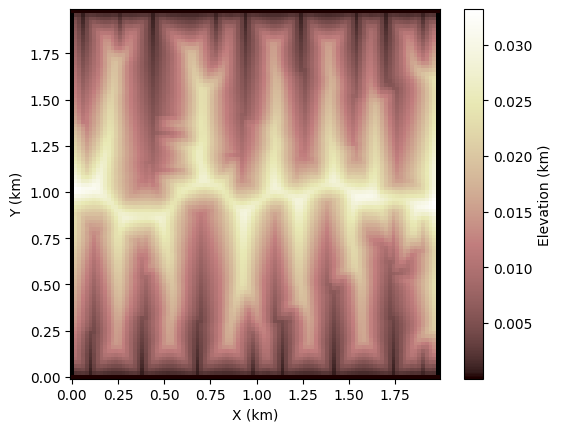

In [8]:
meshWithDiffusion = timeLoopDriver(lin_diffuse, fr, sp, mesh, 
                                 elev, dt, uplift_per_step, totalNumOfTimeSteps,
                                diffusionOrNot=True)
figure("topo with diffusion")
imshow_grid(
    meshWithDiffusion, "topographic__elevation", grid_units=["km","km"], var_name="Elevation (km)")

We've smoothed away the fine-scale channel roughness, as expected, and produced some lovely convex-up hillslopes in its place. Note that even though the initial conditions were identifical in both cases, including the roughness, the channel positions have been moved significantly by the hillslop diffusion into the channel.

## Evolving channel profiles affected by a stochastic storm sequence and diffusion with varying time steps
To demonstrate the effect of storms, diffusion is only allowed during storms. In addition, a slope-area plot for the final conditions will be generated in the end. 

In [9]:
from matplotlib.pyplot import loglog

from landlab.components import ChannelProfiler, PrecipitationDistribution

In [10]:
elev[:] = initial_roughness # reset initial elevations

dt = 0.1
total_t = 250.0

storm_inputs = {"mean_storm_duration":0.1, "mean_storm_depth":0.2,
               "mean_interstorm_duration":0.4}

# instantiate a storm generator
precip = PrecipitationDistribution(total_t=total_t, delta_t=dt, **storm_inputs)
print(storm_inputs)

{'mean_storm_duration': 0.1, 'mean_storm_depth': 0.2, 'mean_interstorm_duration': 0.4}


made it to time 0
made it to time 20
made it to time 40
made it to time 60
made it to time 80
made it to time 100
made it to time 120
made it to time 140
made it to time 160
made it to time 180
made it to time 200
made it to time 220
made it to time 240


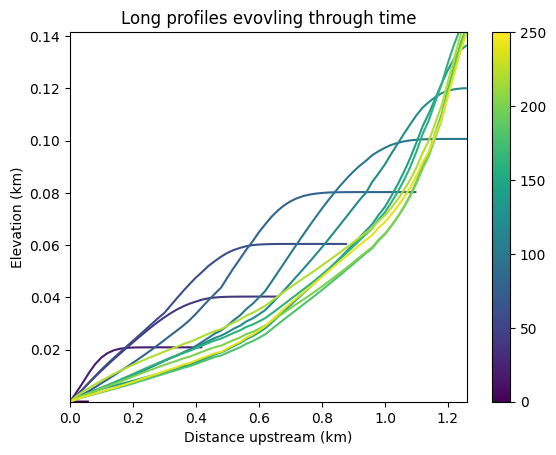

In [11]:
norm = mpl.colors.Normalize(vmin=0, vmax=total_t)
map_color = cm.ScalarMappable(norm=norm, cmap="viridis")

out_interval = 20.0
last_trunc = total_t 
for (
    interval_duration, 
    rainfall_rate,
) in precip.yield_storm_interstorm_duration_intensity():
    if rainfall_rate > 0.0:
        #print('Diffusion only happens when it is raining')
        fr.run_one_step()
        sp.run_one_step(interval_duration)
        lin_diffuse.run_one_step(interval_duration)
    
    elev[mesh.core_nodes] += uplift_rate * interval_duration
    this_trunc = precip.elapsed_time // out_interval
    
    if this_trunc != last_trunc:
        print("made it to time %d" % (out_interval * this_trunc))
        last_trunc = this_trunc
        figure("long_profiles")
        #print("get and plot the longest profile")
        cp = ChannelProfiler(mesh)
        cp.run_one_step()
        cp.plot_profiles(color=map_color.to_rgba(precip.elapsed_time))
        
figure("long_profiles")
xlabel("Distance upstream (km)")
ylabel("Elevation (km)")
title("Long profiles evovling through time")
mpl.pyplot.colorbar(map_color, ax=mpl.pyplot.gca())

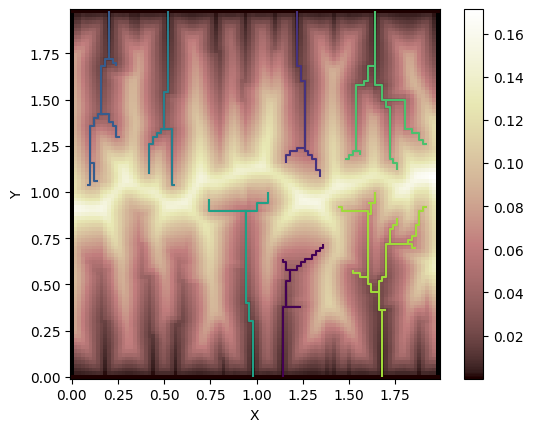

In [12]:
# visualize channels
cp = ChannelProfiler(
    mesh, number_of_watersheds=7, minimum_channel_threshold=0.01, 
    main_channel_only=False
)
cp.run_one_step()
cp.plot_profiles_in_map_view()

Text(0.5, 1.0, 'Slope-Area plot for whole landscape')

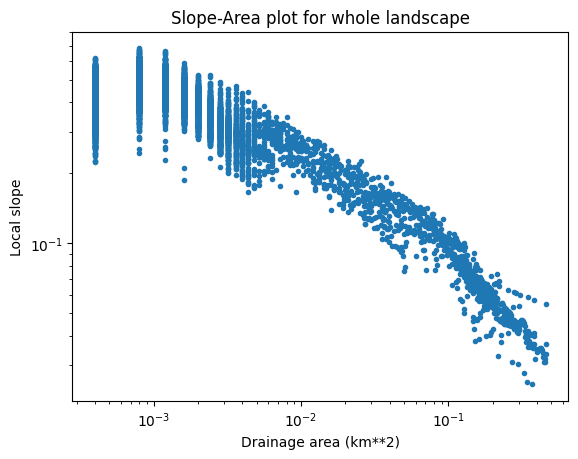

In [13]:
figure("final slope-area plot")
loglog(mesh.at_node["drainage_area"], mesh.at_node["topographic__steepest_slope"], ".")
xlabel("Drainage area (km**2)")
ylabel("Local slope")
title("Slope-Area plot for whole landscape")